In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# import matplotlib
# matplotlib.rc('font', family='Malgun Gothic') # 한글 폰트 설정

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['data.csv']


 ---
 **Abstract**: This is a transnational data set which contains all the
 transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and
 registered non-store online retail.

 ---
  더 나은 서비스를 제공하기 위해서는 고객을 나누어 볼 필요가 있습니다. 
 각각의 고객군은 그 특성 만큼이나 다른 니즈를 가지고 있습니다. 
 이번 *notebook*에서는 E-Commerce 데이터를 활용하여 고객분석을 진행합니다.

 ---
   
  **1. Data Preparation**
  
  **2. Cohort Analysis**

  **3. RFM Analysis**
 
  ---
 

### 1. Data Preparation
 분석 하기에 앞서 데이터를 살펴보고 정리하는 작업을 합니다. 

In [2]:
commerce = pd.read_csv('../input/data.csv', encoding="ISO-8859-1",
                      parse_dates=['InvoiceDate'], dtype={'CustomerID':str})

print(commerce.info())
print("DataFrame Dimensions: ", commerce.shape)
print("\n")
print("null values: {} => {}".format(commerce.columns.values ,commerce.isnull().sum().values))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None
DataFrame Dimensions:  (541909, 8)


null values: ['InvoiceNo' 'StockCode' 'Description' 'Quantity' 'InvoiceDate'
 'UnitPrice' 'CustomerID' 'Country'] => [     0      0   1454      0      0      0 135080      0]


CustomerID 컬럼에 다수의 Null값이 존재합니다. 구분할 수 없는 고객에 대한 데이터는 모두 제거하겠습니다. (약 25%의 데이터에 해당합니다.)

In [3]:
# 75% of data left
commerce = commerce[~pd.isnull(commerce.CustomerID)]

commerce.info()
commerce.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null object
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### 2. [코호트 분석](https://knowledgebase.webengage.com/docs/cohorts)(Cohort Analysis)
코호트 분석은 고객을 "*특정 기간 동안 같은 특성을 가지는 그룹군* "으로 나누어 보는 분석법입니다. 분류된 그룹은 상호 베타적(mutually exclusive)입니다.

&nbsp;

**Acquisition  Cohort**

고객이 처음 서비스에 가입한 시기로 그룹을 분류합니다. 특정 기간(일, 월 등)에 따라 그룹의 행동패턴을 비교/분석합니다. 사용자 생애 주기의 여러 단계에 위치해 있는 고객군을 분석함으로써 전반적인 비즈니스 상태를 이해할 수 있습니다. 단, 지표 값에 대한 이유나 원인은 파악하지 못하는 한계가 있습니다.
 - 매출, 이탈률 등 어떤 지표에 대해서든 가능합니다
 - eg. 3월에 서비스에 가입한 그룹, 4월에 서비스에 가입한 그룹 ···

&nbsp;

**Behavioral Cohort**

고객이 서비스 안에서 할 수 있는 특정 행동을 기준으로 그룹을 분류 후, 그룹의 행동패턴을 비교/분석합니다. 지표 값과 특정 행동간의 상관관계를 파악할 수 있습니다. 단, 인과관계는 설명하지 못하는 한계가 있습니다. A/B 테스트, 다변량 테스트 등을 통하여 인과관계(일 가능성이 높은 것)을 찾아낼 수 있습니다.
 
 - 게시글 수 3개 이상, 친구 추가 100명 이상 등, 서비스 내 모든 액션에 대해서 가능합니다.
 - 복수의 행동에 대해서도 그룹을 분류 할 수 있습니다. 
 - eg. 친구가 100명 이상이면서 게시글이 3개 이상인 그룹 등
 
&nbsp;

이번 노트북에서는 주어진 데이터를 바탕으로 가상의 Acquisition Cohort를 작성하겠습니다.

In [4]:
# Add Invoice Month
commerce['InvoiceMonth'] = commerce['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))

# Add Acquisition Month
commerce['AcquisitionMonth'] = commerce.groupby(by=['CustomerID'])['InvoiceMonth'].transform('min')

# Top 5 rows
commerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,AcquisitionMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


In [5]:
# Add Cohort Index by assigning time offset value
years_diff = commerce.InvoiceMonth.dt.year - commerce.AcquisitionMonth.dt.year
months_diff = commerce.InvoiceMonth.dt.month - commerce.AcquisitionMonth.dt.month

time_offset = years_diff * 12 + months_diff

# Add column
commerce['CohortIndex'] = time_offset
# Top 2 rows
commerce.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,AcquisitionMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0


In [6]:
# Add Total Amount
commerce['Amt'] = commerce.UnitPrice * commerce.Quantity

**Cohort**
1. Acquisition
2. Retention Rate 

**Acquisition Cohort**

In [7]:
# Acquisition
ac_cohort = commerce.pivot_table(index='AcquisitionMonth', columns='CohortIndex',
                                 values='CustomerID', aggfunc=lambda x: x.nunique())
ac_cohort

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
AcquisitionMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Retention Rate Cohort**

In [8]:
# Retention Rate Cohort

# 월별 최초 유입 고객수
size = ac_cohort.iloc[:,0]

# 잔존율
retention = ac_cohort.divide(size, axis=0)
retention.round(2) * 100

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
AcquisitionMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.0,33.0,39.0,36.0,40.0,38.0,35.0,35.0,39.0,37.0,50.0,27.0
2011-01-01,100.0,24.0,28.0,24.0,33.0,30.0,26.0,26.0,31.0,35.0,37.0,15.0,NaN
2011-02-01,100.0,25.0,19.0,28.0,27.0,25.0,26.0,28.0,26.0,31.0,9.0,NaN,NaN
2011-03-01,100.0,19.0,25.0,22.0,23.0,18.0,26.0,24.0,29.0,9.0,NaN,NaN,NaN
2011-04-01,100.0,23.0,22.0,21.0,21.0,24.0,23.0,26.0,8.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,24.0,17.0,17.0,22.0,24.0,27.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,21.0,19.0,27.0,25.0,34.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,21.0,20.0,23.0,27.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.0,25.0,25.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


히트맵을 이용하여 시각화하겠습니다.


In [9]:
retention.index = retention.index.astype(str)

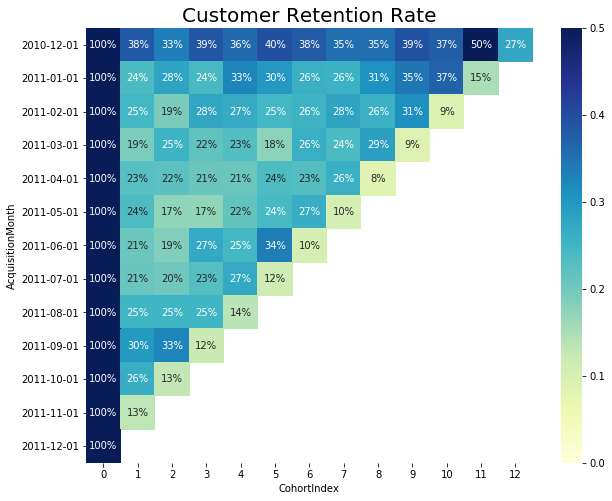

In [10]:
# Retention Rate 
plt.figure(figsize=(10,8))
plt.title('Customer Retention Rate', fontsize=20)
sns.heatmap(data=retention, annot=True, fmt='0.0%', vmin=0.0, vmax=0.5, cmap='YlGnBu')

### 3. [RFM 분석](https://m.blog.naver.com/PostView.nhn?blogId=bestinall&logNo=221274298234&proxyReferer=https%3A%2F%2Fwww.google.com%2F)
고객의 과거 구매이력을 바탕으로 고객군을 분류하는 기법입니다. RFM은 Recency, Frequency, Monetary의 약자로 고객의 가치를 다음의 세 가지 기준에 의해 계산합니다. 대개 직전 과거 12개월을 대상으로 합니다. 

&nbsp;

**Three Metrics**
- **Recency** (거래의 최근성) : 고객이 얼마나 최근에 구입했는가?
- **Frequency** (거래빈도) : 고객이 얼마나 빈번하게 우리 상품을 구입했나? 
- **Monetary Value** (거래규모) : 고객이 구입했던 총 금액은 어느 정도인가?

**Grouping Method**
- **Percentiles**(백분위수): eg. quartiles(사분위수), quintiles(오분위수) 등
- **Custom** : 도메인 놀리지를 활용하여 고객 그룹 분류

이번 노트북에서는 사분위수를 활용하여 고객 그룹을 분류 및 스코어링합니다.
실제 CRM에 적용할 때는 산업, 회사의 특정에 맞게 R.F.M의 중요도에 따라 가중치를 부여하여 스코어링하는 것이 더 합리적입니다.

In [11]:
print("first date: ", commerce.InvoiceDate.min(), 
      "\nlast date: ",commerce.InvoiceDate.max())

first date:  2010-12-01 08:26:00 
last date:  2011-12-09 12:50:00


데이터의 마지막 날짜는 2011년 12월 9일 입니다. 마지막날의 다음날인 10일 날을 기준으로 RFM 분석을 진행합니다.

In [12]:
snapshot_date = commerce.InvoiceDate.max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [13]:
# RFM Table
RFM_Table = commerce.pivot_table(index='CustomerID', values=['InvoiceDate', 'InvoiceNo', 'Amt'],
                                 aggfunc={'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                          'InvoiceNo': 'count',
                                          'Amt': 'sum'}).round()
RFM_Table.rename(columns={'InvoiceDate': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'Amt': 'MonetaryValue'}, inplace=True)

RFM_Table = RFM_Table[['Recency', 'Frequency', 'MonetaryValue']]

RFM_Table.sort_values(by=['MonetaryValue'], ascending=False).head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
14646,2,2085,279489.0
18102,1,433,256438.0
17450,8,351,187482.0
14911,1,5903,132573.0
12415,24,778,123725.0


In [14]:
RFM_Table.sort_values('MonetaryValue', ascending=True).head(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
17448,145,1,-4288.0
15369,144,1,-1592.0
14213,372,5,-1192.0
17603,50,15,-1165.0
12503,338,1,-1126.0


In [15]:
# Describe Recency Value
RFM_Table.Recency.describe()

count    4372.000000
mean       92.047118
std       100.765435
min         1.000000
25%        17.000000
50%        50.000000
75%       143.000000
max       374.000000
Name: Recency, dtype: float64

In [16]:
# Describe Frequency Value
RFM_Table.Frequency.describe()

count    4372.000000
mean       93.053294
std       232.471608
min         1.000000
25%        17.000000
50%        42.000000
75%       102.000000
max      7983.000000
Name: Frequency, dtype: float64

In [17]:
# Describe MonetaryValue Value
RFM_Table.MonetaryValue.describe()

count      4372.000000
mean       1898.462489
std        8219.336392
min       -4288.000000
25%         293.000000
50%         648.000000
75%        1612.000000
max      279489.000000
Name: MonetaryValue, dtype: float64

In [18]:
# 실수값을 기준으로 등급(카테고리)를 나누겠습니다. 
# 사분위수를 기준으로 갯수가 똑같은 그룹을 만들기 위해서 qcut을 이용합니다.
R_labels = range(4,0,-1); F_labels = range(1,5); M_labels = range(1,5)

R_score = pd.qcut(RFM_Table.Recency, 4, labels=R_labels)
F_score = pd.qcut(RFM_Table.Frequency, 4, labels=F_labels)
M_score = pd.qcut(RFM_Table.MonetaryValue, 4, labels=M_labels)

RFM_Table['R'] = pd.to_numeric(R_score)
RFM_Table['F'] = pd.to_numeric(F_score)
RFM_Table['M'] = pd.to_numeric(M_score)

RFM 등급을 활용하여 고객군(Customer Segment)를 나누고 점수(Score)를 부여합니다.

In [19]:
RFM_Table['RFM_Segment'] = RFM_Table.R.astype(str) + RFM_Table.F.astype(str) + RFM_Table.M.astype(str)
RFM_Table['RFM_Score'] = RFM_Table[['R','F','M']].sum(axis=1)

RFM_Table.head(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,2,0.0,1,1,1,111,3
12347,2,182,4310.0,4,4,4,444,12
12348,75,31,1797.0,2,2,4,224,8


RFM 세그먼트 분류에 따라 총 64개(4x4x4)의 그룹이 만들어졌습니다. 64개의 고객 그룹에 대해서 살펴보는 것도 좋은 방법이겠지만, 너무 많다고 생각되기 때문에 Score를 기준으로 좀 더 그룹을 압축하겠습니다.

In [20]:
RFM_Summary = RFM_Table.reset_index().pivot_table(index='RFM_Score', 
                                                  values=['CustomerID','Recency','Frequency','MonetaryValue',
                                                          'R', 'F', 'M'],
                                                  aggfunc={'CustomerID': 'count',
                                                           'Recency': 'mean',
                                                           'Frequency': 'mean',
                                                           'MonetaryValue': 'mean',
                                                           'R': 'mean',
                                                           'F': 'mean',
                                                           'M': 'mean'}).round(1)
# 각 Segment별 비율을 추가합니다. 전체 고객수로 각 세그먼트를 나누어줍니다.
total_customer = RFM_Summary['CustomerID'].sum()
RFM_Summary['Percentage'] = (RFM_Summary['CustomerID'] / total_customer * 100).round(1)

# 컬럼 순서를 조정합니다.
RFM_Summary = RFM_Summary[['CustomerID', 'Percentage', 'R', 'F', 'M', 
                           'Recency','Frequency','MonetaryValue']]

# 컬럼명을 변경합니다.
RFM_Summary.rename(columns={'CustomerID': 'Count',
                            'Recency': 'Recency Mean',
                            'Frequency': 'Frequency Mean',
                            'MonetaryValue': 'MonetaryValue Mean'}, inplace=True) 
# Count 내림차순 정렬
RFM_Summary.sort_values('Count', ascending=False, inplace=True)

# 출력
RFM_Summary

,Count,Percentage,R,F,M,Recency Mean,Frequency Mean,MonetaryValue Mean
RFM_Score,,,,,,,,
5,516,11.8,1.7,1.6,1.6,153.1,21.2,346.9
12,471,10.8,4.0,4.0,4.0,6.7,371.8,8850.7
6,468,10.7,2.3,1.9,1.9,94.3,28.5,491.8
8,467,10.7,2.6,2.7,2.7,62.8,57.1,976.8
7,448,10.2,2.4,2.2,2.4,78.8,39.7,724.0
10,440,10.1,3.2,3.4,3.4,31.3,115.3,1894.0
9,410,9.4,2.9,3.0,3.1,44.1,79.0,1369.0
3,392,9.0,1.0,1.0,1.0,264.8,7.8,109.1
4,392,9.0,1.5,1.3,1.3,174.4,13.9,227.3


**Visualization of RFM**

RFM 분석 결과를 시각화하겠습니다.


**- Number of Customer by Segment**

12점부터 1점까지의 고객군별 고객 수

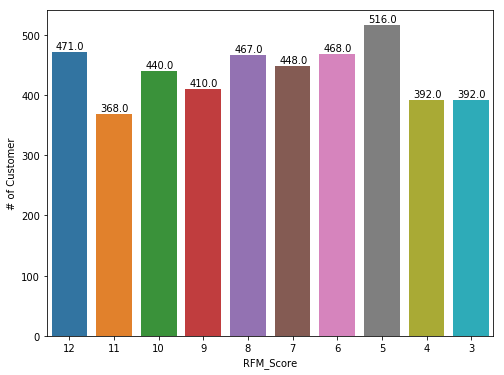

In [101]:
No_Cust = RFM_Table.groupby('RFM_Score').agg({'R': 'count'})
No_Cust = No_Cust.reset_index().sort_values(['RFM_Score'], ascending=False)
No_Cust.rename(columns={'R': '# of Customer'}, inplace=True)

# barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=No_Cust, x='RFM_Score', y='# of Customer',
                 order=No_Cust['RFM_Score'])
for i in ax.patches:
    ax.annotate(i.get_height(), (i.get_x()+0.1, i.get_height()+5))
    

**- Recency X Frequency**

최근성 x 빈도 히트맵은 최근 또는 자주 거래하는 고객을 나타냅니다. 맨 오른쪽 하단은 최근 자주 거래한 고객에 해당합니다. 

고객은 사분위수를 순서에 따라 점수가 매겨졌습니다. 예를 들어 전체 고객중 가장 최근 거래 빈도가 높았던 고객들은 최근성 4점에 해당합니다. 빈도도 동일한 방식을 따릅니다.

In [29]:
# Receny X Frequency Table
RxF = RFM_Table.reset_index().pivot_table(index='R', columns='F', 
                                          values='CustomerID', aggfunc='count')
total = RxF.sum().sum()
print(RxF)

F    1    2    3    4
R                    
1  523  355  163   47
2  301  337  291  150
3  181  248  329  316
4  105  162  296  568


In [30]:
# Percentage table
RxF = (RxF / total).round(3)
RxF

F,1,2,3,4
R,,,,
1,0.120,0.081,0.037,0.011
2,0.069,0.077,0.067,0.034
3,0.041,0.057,0.075,0.072
4,0.024,0.037,0.068,0.130


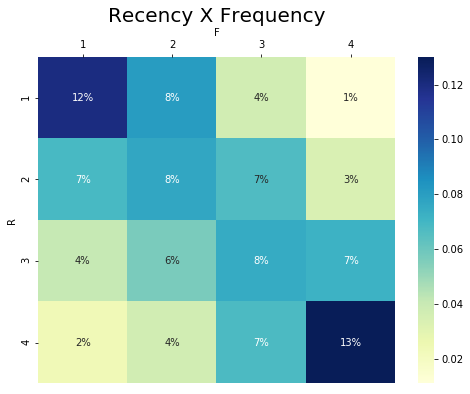

In [51]:
plt.figure(figsize=(8,6))
plt.title('Recency X Frequency', fontsize=20)
ax = sns.heatmap(data=RxF, annot=True, fmt='0.0%', cmap='YlGnBu')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

오른쪽 하단(4행 4열)의 고객군(568명)이 가장 활동성이 우수한 고객 집단이라 할 수 있습니다.
- 4행4열: 단골 고객 (13%)
- 1행4열: 예전 고객 (1%)
- 4행1열: 신규 고객 (2%)
- 1행1열: 일반 고객 (12%)

으로 생각해 볼수 있습니다. 이번 노트북에서는 4분위수

**- Average Receny days**


RFM Score그룹별 Recnecy 평균일 (Recency: 마지막 거래일로부터 경과일)

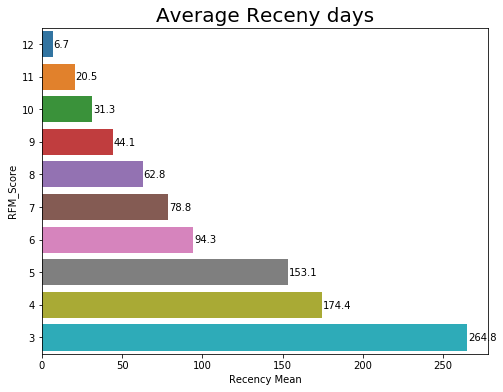

In [79]:
Ave_Recency = RFM_Summary.iloc[:,[5]].sort_index(ascending=False).reset_index()
Ave_Recency.RFM_Score = Ave_Recency.RFM_Score.astype('category')

plt.figure(figsize=(8,6))
plt.title('Average Receny days', fontsize=20)
ax = sns.barplot(data=Ave_Recency,x='Recency Mean', y='RFM_Score', 
                 order=Ave_Recency['RFM_Score'])
for i in ax.patches:
    ax.annotate(i.get_width(), (i.get_width()+0.5, i.get_y()+0.5))

**- Average Monetary Value**


RFM Score그룹별 Monetary 평균

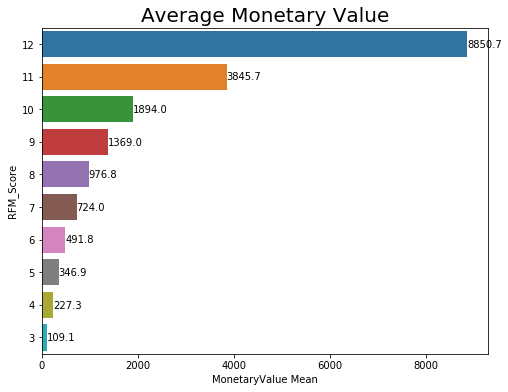

In [103]:
Ave_Money = RFM_Summary.iloc[:,[7]].sort_index(ascending=False).reset_index()
Ave_Money.RFM_Score = Ave_Recency.RFM_Score.astype('category')

plt.figure(figsize=(8,6))
plt.title('Average Monetary Value', fontsize=20)
ax = sns.barplot(data=Ave_Money,x='MonetaryValue Mean', y='RFM_Score', 
                 order=Ave_Money['RFM_Score'])
for i in ax.patches:
    ax.annotate(i.get_width(), (i.get_width()+0.5, i.get_y()+0.5))

**End.**